# 0 - Imports 

In [1]:
import numpy as np
from pathlib import Path
import scipy.io as sio
from scipy.interpolate import interp2d
import imageio
import cv2
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, models, transforms
import time

from skimage import data, draw
from skimage.registration import phase_cross_correlation
import skimage.io
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.transform import warp

from spyrit.misc.disp import *
from spyrit.misc.metrics import *
from spyrit.learning.dataset import *
import spyrit.misc.walsh_hadamard as wh
from spyrit.learning.model_Had_DCAN import *


from scipy.linalg import block_diag
from scipy.interpolate import griddata, RectBivariateSpline
from scipy import sparse
from scipy.sparse import csc_array, diags


In [2]:
def warp(I1, flow):
    """Bonne fonction"""
    h, w = flow.shape[:2];
    flow[:,:,0] += np.arange(w)
    flow[:,:,1] += np.arange(h)[:,np.newaxis]
    I2 = cv2.remap(I1, flow, None, cv2.INTER_LINEAR);
    return I2;

def float2_bit_0_1(I):
    I_8_bit = 255*I;
    I_8_bit = I_8_bit.astype('uint8')
    return I_8_bit

def float2_bit(I):
    I_8_bit = 255*(I+1)/2
    I_8_bit = I_8_bit.astype('uint8')
    return I_8_bit

def float2_bit_gen(I):
    I_8_bit = 255*(I-np.amin(I))/(np.amax(I)-np.amin(I))
    I_8_bit = I_8_bit.astype('uint8')
    return I_8_bit

def flow_farneback(I1, I2, pyramid_scale = 0.5, n_p_layers = 3, w_size = 10, niter = 3, nb_hood = 5):
    I1_8_bit = float2_bit_gen(I1);
    I2_8_bit = float2_bit_gen(I2);
    flow = cv2.calcOpticalFlowFarneback(I1_8_bit, I2_8_bit, None, pyramid_scale, n_p_layers, w_size, niter, nb_hood, 1.2, 0) 
    # None = flow, 0.5 = pyramid scale, 3 = number of pyramid layers, 10 = window_size,  3 = niter, 5 = size of the pixel neighborhood used to find polynomial expansion 
    # None, 0.5, 3, 10, 3, 5, 1.2, 0)
    return flow;

In [3]:
def boule_vid_parabola(n, r, n_frames, v):
    x = np.linspace(-1, 1, n);
    y = np.linspace(-1, 1, n);
    X, Y = np.meshgrid(x, y);
    Vid = np.zeros((n_frames,n,n))
    for i in range(n_frames):
        t = v*i/n_frames;
        x_c = t;
        y_c =  t*(t-1);
        msk = 1.0*((X-x_c)**2+(Y-y_c)**2<r);
        Vid[i,:,:] = msk;
    return Vid;

In [4]:
data_root = "../../data/UCF-101";
dataset_path="../../data/UCF-101-frames";
split_path="../../data/ucfTrainTestlist";
batch_size=256;
img_size=64;
num_frames=21;

np.random.seed(seed=0)
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.FloatTensor;
if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
image_shape = (1, img_size, img_size)
# Define training set
train_dataset = Dataset_prediction(
    dataset_path = dataset_path,
    split_path = split_path,
    split_number = 1,
    input_shape = image_shape,
    sequence_length = num_frames,
    training = True,
)
trainloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=4)
# Define test set
test_dataset = Dataset_prediction(
    dataset_path = dataset_path,
    split_path = split_path,
    split_number = 1,
    input_shape = image_shape,
    sequence_length = num_frames,
    training=False,
)
testloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, num_workers = 4)
dataloaders = {'train':trainloader, 'val':testloader}

/home/lorente/.conda/envs/spyrit-env/lib/python3.8/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


# 1 - Sampling Strategy

## 1.1 - Description 
----------------------------------------
/!\ DISCLAIMER : This part is mostly "intuitive", and we have no solid evidence that this is the best strategy to sample the image of the scene over time. We are presenting it because in order to evaludate the different reconstruction methods, we need a fixed pattern for the sampling strategy that needs to be the same for all reconstruction methods.

----------------------------------------


Let $\mathbf{H} = [ \mathbf{H}_0^\top, \dots,  \mathbf{H}_L^\top  ]^\top \in \mathbb{R}^{N \times N}$ be the Hadamard Transform matrix where the basis functions are ranked in order of highest to lowest energy (i.e. $\mathbf{H}_0 \in \mathbb{R}^{M \times N}$ has the patterns with higher energy - the lower frequency patterns; and $\mathbf{H}_L \in \mathbb{R}^{M \times N}$ has the patterns with lower energy - the higher frequency patterns).
the blocks $\mathbf{H}_i$ of $\mathbf{H}$ are all of same size (i.e. $N = L\times M$).

We can further divide the matrix $\mathbf{H}$ with 3 sets : the set of low frequencies that we want to acquire often $\mathbf{H}_{0,L_0} = [ \mathbf{H}_0^\top, \dots,  \mathbf{H}_{L_0}^\top  ]^\top \in \mathbb{R}^{(M*L_0) \times N}$, the set of frequencies that we want to acquire every now and then $\mathbf{H}_{L_0+1, L_1} = [ \mathbf{H}_{L_0+1}^\top, \dots,  \mathbf{H}_{L_1}^\top  ]^\top \in \mathbb{R}^{(L_1-L_0) \times N}$, and the set of frequences that we do not want to acquire $\mathbf{H}_{L_1+1, L} = [ \mathbf{H}_{L_1+1}^\top, \dots,  \mathbf{H}_{L}^\top  ]^\top \in \mathbb{R}^{(L-L_1) \times N}$.

For every time step, we acquire 
\begin{equation*}
\mathbf{m}_{t} = \mathbf{P}_t \mathbf{f}_t + \epsilon_t^\alpha.
\label{eq:meas} \tag{1}
\end{equation*}

We propose to chose $\mathbf{P}_t$ as 
\begin{equation*}
    \mathbf{P}_{t} = [ \mathbf{H}_{\sigma_1(t)}^\top,  \mathbf{H}_{\sigma_2(t)}^\top  ]^\top, 
\label{eq:choice_matrix} \tag{2}
\end{equation*}
where $\sigma_1(t) =( t \% L_0)$, and $\sigma_2(t) =( L_0+(t \% (L_1-L_0)))$ for all $t \in \mathbb{N}$.

Ideally, $L_0 \ll L_1$. That way, we can measure the 

## 1.2 - Implementation

Load and order the lines of $\mathbf{H}$ according to the covariance matrix computed on the stl-10 dataset.

In [5]:
img_size = 64
H = wh.walsh2_matrix(img_size) / img_size
Mean = np.load('./data/Average_64x64.npy')/img_size
Cov  = np.load('./data/Cov_64x64.npy')/img_size**2

Var = Cov2Var(Cov);
Perm = Permutation_Matrix(Var);
H_perm = img_size*np.dot(Perm,H);

Create a function that defines how to extract the sub-matrices from $\mathbf{H}$.

In [6]:
def extract_high_low_res_matrices(H, t, M, L0, L1):
    N = H.shape[1]; 
    H_out = np.zeros((2*M, N));
    # Low frequence patterns
    low_index = (t%L0)*M;
    high_index = (t%L0+1)*M;
    print("H0 = [{},{}]".format(low_index, high_index))
    H_out[:M,:] = H[low_index:high_index,:];
    # Low frequence patterns
    low_index = (L0+(t%(L1-L0)))*M;
    high_index = (L0+(t%(L1-L0)+1))*M;
    print("H1 = [{},{}]".format(low_index, high_index))
    H_out[M:,:] = H[low_index:high_index,:];
    return H_out;

def extract_high_low_res_matrices_bis(H, t, M0, M1, L0, L1):
    N = H.shape[1]; 
    H_out = np.zeros((M0+M1, N));
    # Low frequence patterns
    low_index = (t%L0)*M0;
    high_index = (t%L0+1)*M0;
    print("H0 = [{},{}]".format(low_index, high_index))
    H_out[:M0,:] = H[low_index:high_index,:];
    # Low frequence patterns
    low_index = L0*M0+(t%(L1-L0))*M1;
    high_index = L0*M0+(t%(L1-L0)+1)*M1;
    print("H1 = [{},{}]".format(low_index, high_index))
    H_out[M0:,:] = H[low_index:high_index,:];
    return H_out;


Defining values for the simulation

In [7]:
L0 = 1;
L1 = 5;
M = 125;

## 2 - Kalman Filter for single-pixel imaging

## 2.1 - Theory
We assume a system follows the following equations :
\begin{equation*}
\begin{cases}
    \mathbf{f}_{t+1} = \mathbf{A}_t \mathbf{f}_{t}+ \epsilon_t\\
    \mathbf{m}_{t} = \mathbf{P}_{t}\mathbf{f}_{t}+\mathbf{\epsilon}^\alpha_{t}.
  \end{cases}
\label{eq:general_formulation} \tag{3}
\end{equation*}

Where 

\begin{align}
\mathbf{\epsilon}_{t} \sim \mathcal{N}( \mathbf{0}, \mathbf{\Sigma}_t), \label{eq:meas_noise} \tag{4.1}\\
\mathbf{\epsilon}^\alpha_{t} \sim \mathcal{N}( \mathbf{0}, \mathbf{\Sigma}^\alpha_t), \label{eq:mod_noise} \tag{4.2}
\end{align}

* **Initialisation** : $\mathbf{f}^+_0$, $\mathbf{C}_0^+$ are obtained by :

 * $\mathbf{f}^+_0 = \mathbb{E}(\mathbf{f}_0|\mathbf{m}^\alpha_0)$.
 * $\mathbf{C}_0^+ = \mathbb{V}\text{ar}(\mathbf{f}_0|\mathbf{m}^\alpha_0)$


* **Itérations**
    * **Prior Estimation**
\begin{align}
    \mathbf{f}^-_{t+1} & = \mathbb{E}(\mathbf{f}_{t+1}|\mathbf{m}^\alpha_0, ... ,\mathbf{m}^\alpha_t) \label{eq:prior_mean} \tag{5.1}\\
    \mathbf{C}^-_{t+1} & = \mathbb{V}\text{ar}(\mathbf{f}_{t+1}|\mathbf{m}^\alpha_0, ... ,\mathbf{m}^\alpha_t)
    \label{eq:prior_var} \tag{5.2}
\end{align}
In the context of eq. $\eqref{eq:general_formulation}$, the prior estimation can be done through the following formulas.
\begin{align}
    \mathbf{f}^-_{t+1} & =  \mathbf{A}_t \mathbf{f}^+_{t} \label{eq:prior_mean_gauss} \tag{6.1}\\
    \mathbf{C}^-_{t+1} & = \mathbf{A}_t \mathbf{C}^+_{t} \mathbf{A}_t^\top + \mathbf{\Sigma}_t
    \label{eq:prior_var_gauss} \tag{6.2}
\end{align}

    * **Posterior Estimation**
\begin{align}
    \mathbf{f}^+_{t+1} & = \mathbb{E}(\mathbf{f}_{t+1}|\mathbf{m}^\alpha_0, ... ,\mathbf{m}^\alpha_{t+1}) \label{eq:post_mean} \tag{7.1}\\
    \mathbf{C}^+_{t+1} & = \mathbb{V}\text{ar}(\mathbf{f}_{t+1}|\mathbf{m}^\alpha_0, ... ,\mathbf{m}^\alpha_{t+1}) \label{eq:post_var} \tag{7.2}
\end{align}

Here again, in the context of eq. $\eqref{eq:general_formulation}$, the posterior estimation has an analytical formula.

\begin{align}
    \mathbf{f}^+_{t+1} & = \mathbf{f}_{t+1}^- + \mathbf{C}_{t+1}^- \mathbf{P}_{t+1}^\top (\mathbf{P}_{t+1} \mathbf{C}_{t+1}^- \mathbf{P}_{t+1}^\top+ \mathbf{\Sigma}^\alpha_{t+1})^{-1}(\mathbf{m}_{t+1}^\alpha - \mathbf{P}_{t+1} \mathbf{f}_{t+1}^-) \label{eq:post_mean_gauss} \tag{8.1}\\
    \mathbf{C}^+_{t+1} & = \mathbf{C}_{t+1}^- - \mathbf{C}_{t+1}^- \mathbf{P}_{t+1}^\top (\mathbf{P}_{t+1} \mathbf{C}_{t+1}^- \mathbf{P}_{t+1}^\top+ \mathbf{\Sigma}^\alpha_{t+1})^{-1}\mathbf{P}_{t+1} \mathbf{C}_{t+1}^{- \top} \label{eq:post_var_gauss} \tag{8.2}
\end{align}

Do note that this posterior estimation has a desterministic interpretation, in that Eq. $\eqref{eq:post_mean_gauss}$ can also be written as :

\begin{equation*}
\mathbf{f}^+_{t+1} = \underset{\mathbf{f}}{\text{argmax}} \| \mathbf{P}_{t+1}\mathbf{f}-\mathbf{m}^\alpha_{t+1}\|_{(\mathbf{\Sigma}^{\alpha}_{t+1})^{-1}}^2 + \| \mathbf{f} - \mathbf{f}^-_{t+1}\|^2_{(\mathbf{C}_{t+1}^{-})^{-1}}
\label{eq:optim_posterior} \tag{9}
\end{equation*}


## 2.2 Choices in our linear approach

In order to tackle the single-pixel video problem using the (linear) Kalman filter, we consider the following approximations till the end of Sec. 2. 

First, we consider that the dynamic model $\mathbf{A}_t = \mathbf{I}$, for all $t$. This means, that we consider that the difference between 2 consecutive frames is explained _only_ through noise. 

This model has several advantages :
* The equations are easy to implement
* It is easy to understand

The disadvantages are that :
* All the complexity of the dynamics of the video is put into the noise : we either have complex signal-dependent models(which defeats the purpose of chosing a simple model), or we do not properly translate the dynamics of the scene.
* For signal-independent noise models, when we update the previous image, in the Hadamard domain, we merely keep the previous measurements, and filter the new ones : i.e. we completely fail to take into account all movement within the scene.

That being the case, we visualize different samples of $\epsilon_t = \mathbf{f}_{t+1}-\mathbf{f}_{t}$ to determine if chosing a signal-independent model makes any sense. 

In [8]:
x = next(iter(testloader))
x = x[0];
x.shape

x_t = x[:,1:,:,:,:]
x_t_p = x[:,:-1,:,:,:]
epsilon = x_t - x_t_p
epsilon = epsilon.view((num_frames-1)*batch_size,img_size, img_size);
epsilon = torch2numpy(epsilon)

In [9]:
def Multi_histograms(img_list, Index, shape, suptitle= '', color = "g", n_bins = 50, axis_off = True ,aspect = (16,9), savefig = "", fontsize = 14):
    [rows, cols] = shape;
    plt.figure();
    plt.suptitle(suptitle, fontsize=fontsize);
    if len(Index)<rows*cols:
        for k in range(rows*cols-len(Index)):
            Index.append([0,0])

    for k in range(rows*cols):
        x = img_list[:, Index[k][0], Index[k][1]]
        ax = plt.subplot(rows,cols,k+1)
        ax.hist(x, n_bins, density=True, histtype='bar', color = color, stacked=True)
        ax.set_title("Pixel : ({},{})".format(Index[k][0], Index[k][1]), fontsize=fontsize);
        if axis_off :
            plt.axis('off');
    if savefig:
        plt.savefig(savefig, bbox_inches='tight')
    plt.show()

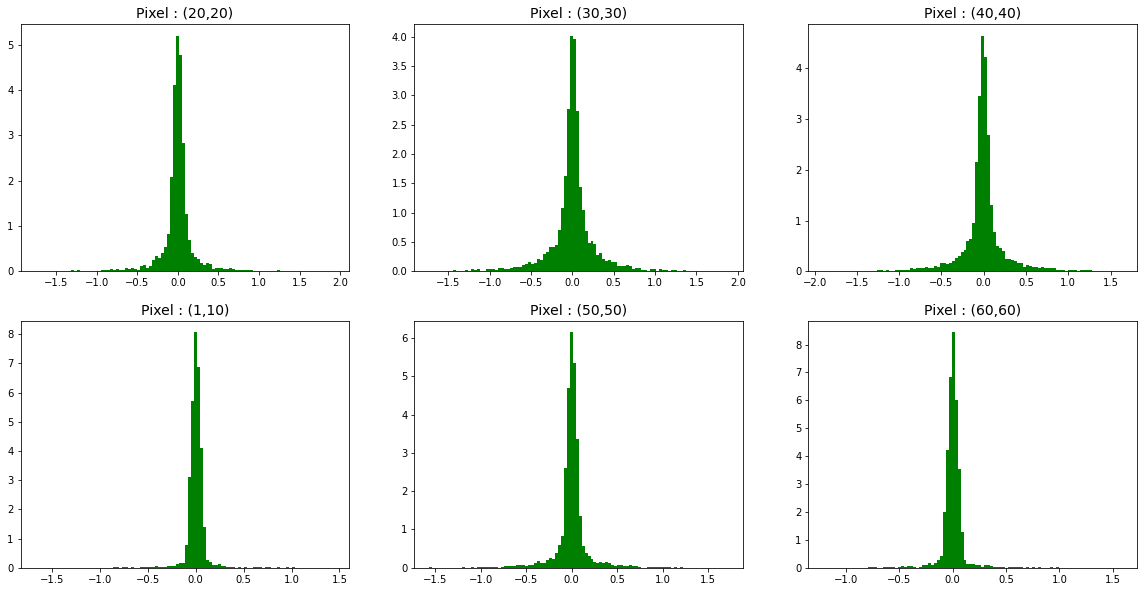

In [10]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]
Index = [[20, 20], [30, 30], [40, 40], [1,10], [50, 50], [60,60]];
shape = [2,3];
Multi_histograms(epsilon, Index, shape, axis_off = False, n_bins = 100, savefig = "")

These are not really normally distributed. They seem a bit more like a Laplace Distribution. That being said, in order to follow the Kalman filter theory, we can still approximate them as being normally distributed. 
These samples of noise seem to be signal-independent, and their statistics can be captured with the covariance and the mean (which they appear to be centered on 0).

/home/lorente/.conda/envs/spyrit-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 1440x720 with 0 Axes>

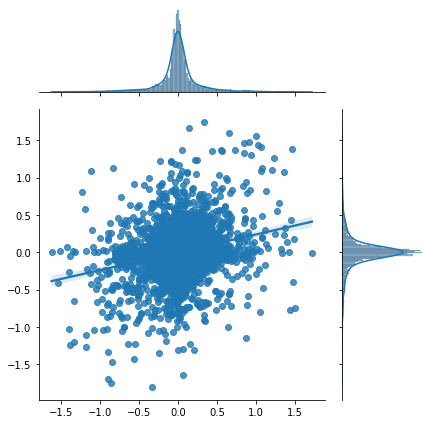

In [11]:
import seaborn as sns
n1 = [30, 26]
n2 = [26,26];

plt.figure();
sns.jointplot(epsilon[:,n1[0], n1[1]], epsilon[:,n2[0], n2[1]], kind='reg', ratio=3)#, xlim=[-2,2], ylim=[-5, 5])
plt.xlabel('Pixel #{}'.format(n1))
plt.ylabel('Pixel #{}'.format(n2))
plt.show()
# plt.savefig("img/scatter_test.pdf")

## 2.3 - Estimation of the model covariance matrix

In [12]:
def Stat_dyn(dataloader, device):
    """ 
        Computes the variance of a predictor based on the identity
    """

    (inputs, classes) = next(iter(dataloader["train"])) # do "val" if too long
    inputs = inputs.cpu().detach().numpy();
    (batch_size, num_frames, channels, nx, ny) = inputs.shape;
    tot_num = 0;
    c = 0;
    Cov_had = np.zeros((nx*ny, nx*ny));
    with torch.no_grad():
        for inputs,labels in dataloader["train"]:
            c +=1;
            print("batch {}/{}".format(c, len(dataloader["train"])))
            inputs = inputs.to(device);
            (batch_size, num_frames,channels, nx, ny) = inputs.shape;
            tot_num +=batch_size*(num_frames-1);
            output = inputs[:,1:, :,:,:];
            inputs = inputs[:,:-1,:,:,:]
            images = output-inputs;
            images = images.view(batch_size*(num_frames-1)*channels,1, nx, ny);
            images = images.cpu().detach().numpy();
            for i in range(images.shape[0]):
                img = images[i,0,:,:];
                Norm_Variable = np.reshape(img, (nx*ny,1));
                Cov_had += Norm_Variable*np.transpose(Norm_Variable);
        Cov_had = Cov_had/(tot_num-1);
    return Cov_had

In [13]:
my_new_cov_file = "./data/Cov_dyn_id_{}x{}.npy".format(img_size, img_size);
if Path(my_new_cov_file).is_file():
    Cov_dyn  = np.load(my_new_cov_file)
else :
    Cov_dyn = Stat_dyn(dataloaders, device)
    np.save(my_new_cov_file, Cov_dyn)

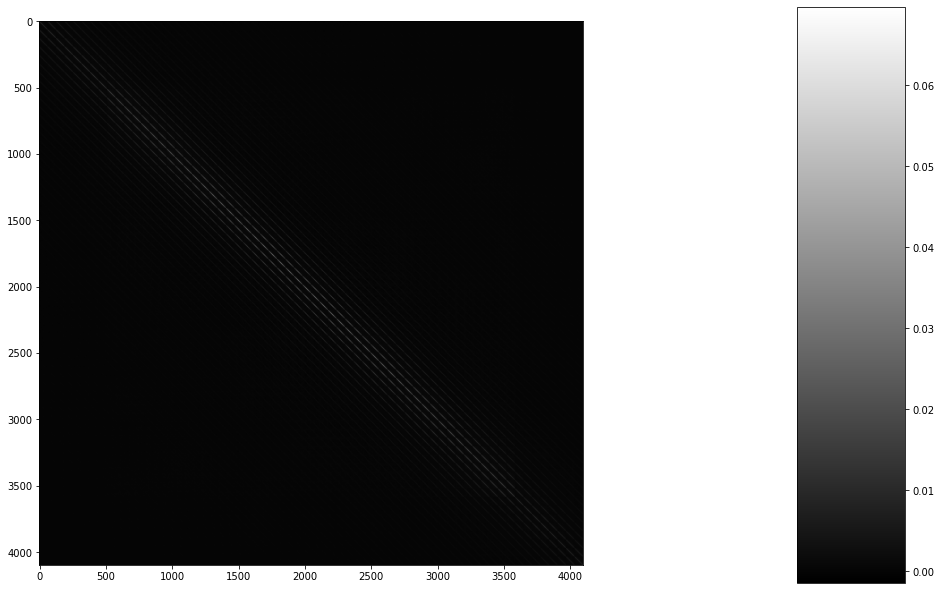

In [14]:
imagesc(Cov_dyn)

It is fair to assume that this matrix is approximatively sparse (I will not exploit it , but it can be exploited!!!!!)

In [15]:
np.sum(Cov_dyn>0.2*np.amax(np.abs(Cov_dyn)))

38043

In [16]:
Cov_dyn_sp = Cov_dyn; # Initially wanted to make it sparse, but for now I keep it as it is.

## 2.4 - Numerical simulations

In [17]:
def Kalman_prior_Id(x_k, P_k, Q_k):
    x_k1 = x_k;
    P_k1 = P_k+Q_k;
    return x_k1, P_k1;

def Kalman_posterior(H, y_k, x_k, P_k, R_k):
    Pat = P_k@H.T;
    K_k = np.linalg.inv(R_k+H@Pat);
    K_k = Pat@K_k;
    x_k1 = x_k + K_k@(y_k-H@x_k);
    P_k1 = P_k - K_k@Pat.T;
    return x_k1, P_k1

def Kalman_step_Id(y_k, x_k, H, P_k, Q_k, R_k):
    # Prior estimation
    x_k, P_k = Kalman_prior_Id(x_k, P_k, Q_k);
    # Posterior estimation
    x_k, P_k = Kalman_posterior(H, y_k, x_k, P_k, R_k);
    return x_k, P_k;

def measure(H, x, N0):
    H_plus = np.zeros(H.shape);
    H_minus = np.zeros(H.shape);
    H_plus[H>0] = H[H>0];
    H_minus[H<0] = -H[H<0];
    y_plus = N0*H_plus@x;
    y_minus = N0*H_minus@x;
    y_plus += np.multiply(np.sqrt(y_plus),np.random.normal(0,1, size = y_plus.shape));
    y_minus += np.multiply(np.sqrt(y_minus),np.random.normal(0,1, size = y_minus.shape));
    return y_plus, y_minus;

def diag(y):
    n = y.shape[0];
    D = np.zeros((n,n));
    D[np.diag_indices(n)] = np.reshape(y,(n,));
    return D;

def Diag(A):
    a,b = A.shape;
    n = min(a,b);
    d = np.reshape(A[np.diag_indices(n)], (n,1));
    return d;


In [18]:
def Denoi_stat_comp(y, Sigma, Sigma_a, H):
    Pat = Sigma@H.T;
    P_k = np.linalg.inv(Sigma_a+H@Pat);
    P_k = Pat@P_k;
    x_k = P_k@y;
    P_k = Sigma - P_k@Pat.T;
    return x_k, P_k

def Denoi_stat_comp_light(y, Sigma, Sigma_a, H):
    Pat = Sigma@H.T;
    P_k = np.linalg.inv(Sigma_a+H@Pat);
    P_k = Pat@P_k;
    x_k = P_k@y;
    return x_k

def Pinv(y, Sigma_a, H):
    M, n = H.shape;
    H_inv = (1/n)*H.T
    x_k = H_inv@y
    P_k = H_inv@Sigma_a@H_inv.T;
    return x_k, P_k

def Pinv_light(y, H):
    M, n = H.shape;
    H_inv = (1/n)*H.T
    x_k = H_inv@y
    return x_k


In [19]:
n_frames = num_frames;
x = 2*boule_vid_parabola(64, 0.025, n_frames, 1)-1
N0 = 5;
Sigma_i = (1/img_size**2)*H.T@Cov@H


In [20]:
print(np.amax(Sigma_i))
print(np.amax(Cov_dyn_sp)) 

8.701842410605056e-05
0.06970001857340348


The Covariance from the dynamic system is very high!!

In [21]:
x_kal = np.zeros((n_frames+1, img_size, img_size))
x_tikh = np.zeros((n_frames+1, img_size, img_size))
x_pinv = np.zeros((n_frames+1, img_size, img_size))


Cov_dyn_sp_prim = diag(Diag(Cov_dyn_sp)) 

for t in range(n_frames):
    print("time =  {}".format(t))
    H_k = extract_high_low_res_matrices(H_perm, t, M, L0, L1)
    One = np.dot(H_k, np.ones((img_size**2,1))) # Optimisable (On connait la valeur avec Hadamard)!
    
    ## Measurement acquisition
    x_k = (x[t,:,:]+1)/2;
    # x_k = (x[0,:,:]+1)/2;
    x_k = np.reshape(x_k, (img_size**2, 1));
    y_k_pos, y_k_neg = measure(H_k, x_k , N0);
    Sigma_a = (y_k_pos+y_k_neg)/(4*N0**2);
    y_k = y_k_pos-y_k_neg;
    y_k = 2/N0*y_k - One;
    Sigma_a = diag(Sigma_a); # peut-être facteur 2...
    
    ## Image reconstruction
    if t == 0:
        t1 = time.time();
        x_kalman, P_k = Denoi_stat_comp(y_k, Sigma_i, Sigma_a, H_k);
        t2 = time.time();
        print("Kalman time = {}".format(t2-t1))
    else:
        t1 = time.time();
        x_kalman, P_k = Kalman_step_Id(y_k, x_kalman, H_k, P_k, Cov_dyn_sp, Sigma_a);
        t2 = time.time();
        print("Kalman time = {}".format(t2-t1))
    t1 = time.time();
    x_tikhonov = Denoi_stat_comp_light(y_k, Sigma_i, Sigma_a, H_k);
    t2 = time.time();
    print("Tikhonov time = {}".format(t2-t1))
    x_pseudo_inv = Pinv_light(y_k, H_k);
    t1 = time.time();
    print("Pinv time = {}".format(t1-t2))
    
    x_kal[t+1,:,:] = np.reshape(x_kalman, (img_size, img_size))
    x_tikh[t+1,:,:] = np.reshape(x_tikhonov, (img_size, img_size))
    x_pinv[t+1,:,:] = np.reshape(x_pseudo_inv, (img_size, img_size))
    


time =  0
H0 = [0,125]
H1 = [125,250]
Kalman time = 0.35825419425964355
Tikhonov time = 0.19987249374389648
Pinv time = 0.005896806716918945
time =  1
H0 = [0,125]
H1 = [250,375]
Kalman time = 0.31780099868774414
Tikhonov time = 0.10866284370422363
Pinv time = 0.0025267601013183594
time =  2
H0 = [0,125]
H1 = [375,500]
Kalman time = 0.289182186126709
Tikhonov time = 0.15915632247924805
Pinv time = 0.0017056465148925781
time =  3
H0 = [0,125]
H1 = [500,625]
Kalman time = 0.40398478507995605
Tikhonov time = 0.1734147071838379
Pinv time = 0.0018398761749267578
time =  4
H0 = [0,125]
H1 = [125,250]
Kalman time = 0.36977291107177734
Tikhonov time = 0.08048772811889648
Pinv time = 0.0018286705017089844
time =  5
H0 = [0,125]
H1 = [250,375]
Kalman time = 0.2953312397003174
Tikhonov time = 0.18210792541503906
Pinv time = 0.0018460750579833984
time =  6
H0 = [0,125]
H1 = [375,500]
Kalman time = 0.289548397064209
Tikhonov time = 0.1299445629119873
Pinv time = 0.002895355224609375
time =  7
H0 = 

In [22]:
x_gt = np.zeros((1,4,1,img_size, img_size));
x_gt[0,0,0,:,:] = x[1,:,:]
x_gt[0,1,0,:,:] = x[5,:,:]
x_gt[0,2,0,:,:] = x[10,:,:]
x_gt[0,3,0,:,:] = x[15,:,:]
x_gt.shape

(1, 4, 1, 64, 64)

In [23]:
x_kalman = np.zeros((1,4,1,img_size, img_size));
x_kalman[0,0,0,:,:] = x_kal[1,:,:]
x_kalman[0,1,0,:,:] = x_kal[5,:,:]
x_kalman[0,2,0,:,:] = x_kal[10,:,:]
x_kalman[0,3,0,:,:] = x_kal[15,:,:]
x_kalman.shape

(1, 4, 1, 64, 64)

In [24]:
x_tikhonov = np.zeros((1,4,1,img_size, img_size));
x_tikhonov[0,0,0,:,:] = x_tikh[1,:,:]
x_tikhonov[0,1,0,:,:] = x_tikh[5,:,:]
x_tikhonov[0,2,0,:,:] = x_tikh[10,:,:]
x_tikhonov[0,3,0,:,:] = x_tikh[15,:,:]
x_tikhonov.shape

(1, 4, 1, 64, 64)

In [25]:
x_pseudo_inv = np.zeros((1,4,1,img_size, img_size));
x_pseudo_inv[0,0,0,:,:] = x_pinv[1,:,:]
x_pseudo_inv[0,1,0,:,:] = x_pinv[5,:,:]
x_pseudo_inv[0,2,0,:,:] = x_pinv[10,:,:]
x_pseudo_inv[0,3,0,:,:] = x_pinv[15,:,:]
x_pseudo_inv.shape

(1, 4, 1, 64, 64)

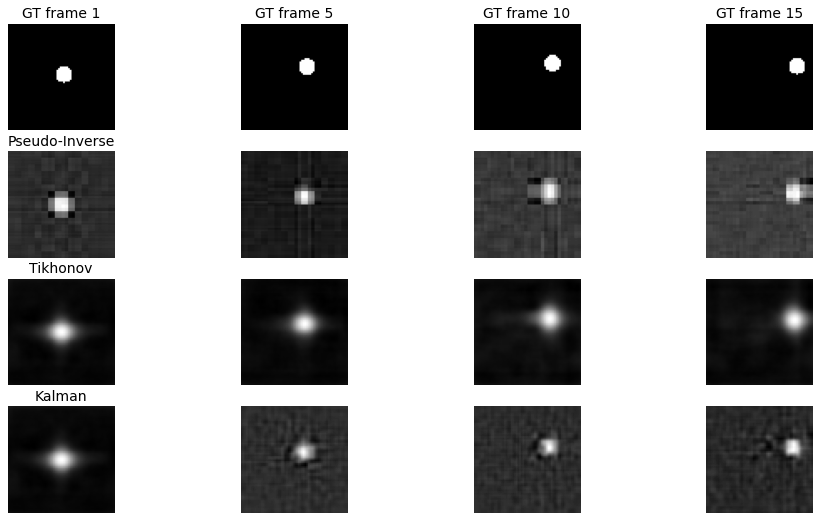

In [26]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 10]

nb_disp_frames = 4
outputs_0 = [x_gt, x_pseudo_inv ,x_tikhonov, x_kalman];
title_lists_0 = [["GT frame 1", "GT frame 5", "GT frame 10", "GT frame 15"]]
title_lists_0.append(["Pseudo-Inverse"]+["" for i in range(3)])
title_lists_0.append(["Tikhonov"]+["" for i in range(3)])
title_lists_0.append(["Kalman"]+["" for i in range(3)])
# title_lists_0.append(["" for i in range(4)])
compare_video_frames(outputs_0, nb_disp_frames, title_lists_0,savefig = '');

Robust to noise!! Despite initial very blurry estimate, there is a real gain over the different frames to get a point of higher resolution!!

# 3 - Extended Kalman filter for single-pixel image estimation
## 3.1 - Theory
For this part, we work under the assumption that we have a dual SPC-RGB camera. Under those circumstances, we can at any given time estimate the optical flow thanks to the RGB camera. So we assume that for every time step $t$, we know $(\hat{\mathbf{u}}_t, \hat{\mathbf{v}}_t) \in \mathbb{R}^{2 \times N}$ such that 
\begin{equation*}
\mathbf{f}_{t+1} \approx \mathcal{W}(\mathbf{f}_{t}, \hat{\mathbf{u}}_{t+1}, \hat{\mathbf{v}}_{t+1}),
\label{eq:flow} \tag{10}
\end{equation*}
where $\mathcal{W}$ is a warping operator defined such that for all pixel with coordinates $[x,y]$,
\begin{equation*}
\mathcal{W}(\mathbf{f}_{t}, \hat{\mathbf{u}}_{t+1}, \hat{\mathbf{v}}_{t+1})[x,y] =  \mathbf{f}_{t}[x+\hat{\mathbf{u}}_{t+1}[x,y],y+\hat{\mathbf{v}}_{t+1}[x,y]]
\label{eq:warp} \tag{11}
\end{equation*}

This operator is non-linear, but we do have the ability to compute it's first derrivative with respect to $\mathbf{f}_t$. We have little to no information on the system noise process $\epsilon_t$ defined by $\epsilon_t = \mathbf{f}_{t+1} - \mathcal{W}(\mathbf{f}_{t}, \hat{\mathbf{u}}_{t+1}, \hat{\mathbf{v}}_{t+1})$. For simplicity, we will observe it in Section 3.2, and make the Gaussian (signal-independent) approximation, where the covariance is constant over time.

Under these circumstances, the equations of the system are 
\begin{equation*}
\begin{cases}
    \mathbf{f}_{t+1} = \mathcal{W}(\mathbf{f}_{t}, \hat{\mathbf{u}}_{t+1}, \hat{\mathbf{v}}_{t+1})+ \epsilon_t,\\
    \mathbf{m}_{t} = \mathbf{P}_{t}\mathbf{f}_{t}+\mathbf{\epsilon}^\alpha_{t},
  \end{cases}
\label{eq:general_formulation} \tag{12}
\end{equation*}
where 
\begin{align}
\mathbf{\epsilon}_{t} \sim \mathcal{N}( \mathbf{0}, \mathbf{\Sigma}), \label{eq:meas_noise} \tag{13.1}\\
\mathbf{\epsilon}^\alpha_{t} \sim \mathcal{N}( \mathbf{0}, \mathbf{\Sigma}^\alpha_t), \label{eq:mod_noise} \tag{13.2}
\end{align}

The reconstruction scheme with the Kalman filter then becomes

* **Initialisation** : $\mathbf{f}^+_0$, $\mathbf{C}_0^+$ are obtained by :
 * $\mathbf{f}^+_0 = \mathbb{E}(\mathbf{f}_0|\mathbf{m}^\alpha_0)$.
 * $\mathbf{C}_0^+ = \mathbb{V}\text{ar}(\mathbf{f}_0|\mathbf{m}^\alpha_0)$

* **Itérations**
    * **Prior Estimation**
\begin{align}
    \mathbf{f}^-_{t+1} & =  \mathcal{W}(\mathbf{f}^+_{t}, \hat{\mathbf{u}}_{t+1}, \hat{\mathbf{v}}_{t+1}),  \label{eq:prior_mean_gauss} \tag{14.1}\\
    \mathbf{C}^-_{t+1} & = \mathbf{A}_t \mathbf{C}^+_{t} \mathbf{A}_t^\top + \mathbf{\Sigma},
    \label{eq:prior_var_gauss} \tag{14.2}
\end{align}
where $\mathbf{A}_t$ is the first derrivative of $\mathcal{W}$ with respect to $\mathbf{f}$, i.e.
\begin{align}
\mathbf{A}_t = \frac{\partial \mathcal{W}}{\partial \mathbf{f}}(\mathbf{f}^+_{t}, \hat{\mathbf{u}}_{t+1}, \hat{\mathbf{v}}_{t+1}) = \mathbf{I}+\text{Diag}(\hat{\mathbf{u}}_{t+1}) \nabla_x + \text{Diag}(\hat{\mathbf{v}}_{t+1}) \nabla_y \label{eq:linearised_warp} \tag{15}
\end{align}
This linearisation can be obtained by doing a first order Taylor expansion of $\eqref{eq:warp}$ in a point $[x,y]$ of space
\begin{equation*}
\mathbf{f}_{t}[x+\hat{\mathbf{u}}_{t+1}[x,y],y+\hat{\mathbf{v}}_{t+1}[x,y]] = \mathbf{f}_{t}[x,y]+\hat{\mathbf{u}}_{t+1}[x,y] \nabla_x \mathbf{f}_t[x,y]+ +\hat{\mathbf{v}}_{t+1}[x,y] \nabla_y \mathbf{f}_t[x,y]
\label{eq:warp_linear} \tag{16}
\end{equation*}
    
    * **Posterior Estimation**
\begin{align}
    \mathbf{f}^+_{t+1} & = \mathbf{f}_{t+1}^- + \mathbf{C}_{t+1}^- \mathbf{P}_{t+1}^\top (\mathbf{P}_{t+1} \mathbf{C}_{t+1}^- \mathbf{P}_{t+1}^\top+ \mathbf{\Sigma}^\alpha_{t+1})^{-1}(\mathbf{m}_{t+1}^\alpha - \mathbf{P}_{t+1} \mathbf{f}_{t+1}^-) \label{eq:post_mean_gauss} \tag{17.1}\\
    \mathbf{C}^+_{t+1} & = \mathbf{C}_{t+1}^- - \mathbf{C}_{t+1}^- \mathbf{P}_{t+1}^\top (\mathbf{P}_{t+1} \mathbf{C}_{t+1}^- \mathbf{P}_{t+1}^\top+ \mathbf{\Sigma}^\alpha_{t+1})^{-1}\mathbf{P}_{t+1} \mathbf{C}_{t+1}^{- \top} \label{eq:post_var_gauss} \tag{17.2}
\end{align}


## 3.2 - Estimation of the covariance


In [27]:
def Stat_dyn_flow(dataloader, device):
    """ 
        Computes the variance of a predictor based on the warping of the image by the optical flow optained with the Farneback method
        /|\ Do not use for now. Gives weird covariance values (higher covariance than the identity!?)
    """
    (inputs, classes) = next(iter(dataloader["val"])) # do "val" if too long
    inputs = inputs.cpu().detach().numpy();
    (batch_size, num_frames, channels, nx, ny) = inputs.shape;
    tot_num = 0;
    c = 0;
    Cov_had = np.zeros((nx*ny, nx*ny));
    with torch.no_grad():
        for inputs,labels in dataloader["val"]:
            c +=1;
            print("batch {}/{}".format(c, len(dataloader["val"])))
            # inputs = inputs.to(device);
            (batch_size, num_frames,channels, nx, ny) = inputs.shape;
            tot_num +=batch_size*(num_frames-1);
            output = inputs[:,1:, :,:,:];
            inputs = inputs[:,:-1,:,:,:];
            output = output.contiguous().view(batch_size*(num_frames-1)*channels,1, nx, ny);
            inputs = inputs.contiguous().view(batch_size*(num_frames-1)*channels,1, nx, ny);
            output = output.cpu().detach().numpy();
            inputs = inputs.cpu().detach().numpy();
            for i in range(inputs.shape[0]):
                img_1 = inputs[i,0,:,:];
                img_2 = output[i,0,:,:];
                flow = flow_farneback(img_1, img_2);
                Norm_Variable = warp(img_1,-flow)-img_2;
                Norm_Variable = np.reshape(Norm_Variable, (nx*ny,1));
                Cov_had += Norm_Variable@Norm_Variable.T;
        Cov_had = Cov_had/(tot_num-1);
    return Cov_had

In [28]:
my_new_cov_file = "./data/Cov_dyn_id_{}x{}.npy".format(img_size, img_size); # Cov_dyn_flow_
if Path(my_new_cov_file).is_file():
    Cov_dyn  = np.load(my_new_cov_file)
else :
    Cov_dyn = Stat_dyn_flow(dataloaders, device)
    np.save(my_new_cov_file, Cov_dyn)

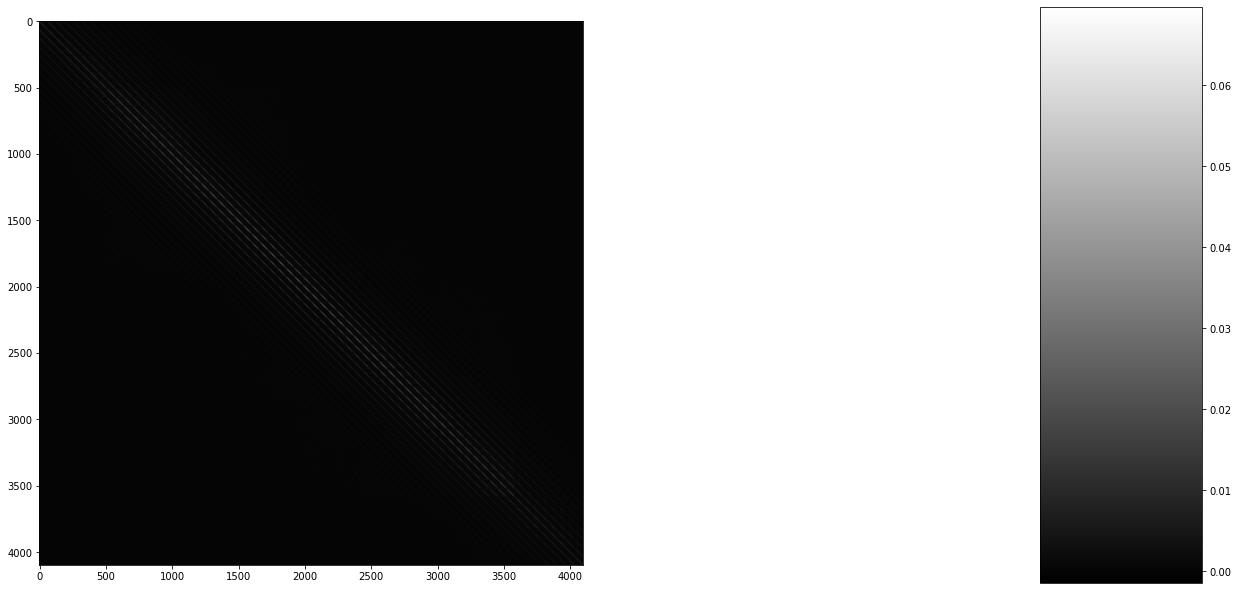

In [29]:
imagesc(Cov_dyn)

In [30]:
# np.sum(Cov_dyn>0.15*np.amax(np.abs(Cov_dyn)))

In [31]:
# Cov_dyn_sp = Cov_dyn;
# Cov_dyn_sp[Cov_dyn<0.15*np.amax(Cov_dyn)] = 0;
# imagesc(Cov_dyn_sp>0);
# Cov_dyn_sp = csc_array(Cov_dyn_sp)

## 3.3 - Numerical Simulations

In [32]:
def grad_x_matrix_centered(nx, ny):
    Dupper = np.diag([1] * (nx-1), 1)
    Dlower = -np.diag([1] * (nx-1), -1)
    D = 1/2*(Dupper + Dlower)
    Ds = [D] * (nx)
    A  = block_diag(*Ds)
    return A

def grad_y_matrix_centered(nx, ny):
    I = np.ones((nx*(ny-1)))
    Iupper = np.diag(I, nx)
    Ilower = -np.diag(I, -(nx))
    A = 1/2*(Iupper + Ilower)
    return A

def linearised_warp_centered(nx,ny, flow):
    Dx = grad_x_matrix_centered(nx, ny);
    Dy = grad_y_matrix_centered(nx, ny);
    Fx = np.diag(np.reshape(flow[:,:,0],(nx*ny)))@Dx;
    Fy = np.diag(np.reshape(flow[:,:,1],(nx*ny)))@Dy;
    F = (-1)*(Fx+Fy); # can just write F = Fx+Fy; for further optimisation bcz (-F)@P_k@(-F.T) = F@P_k@F.T ...
    return F

def grad_x_matrix(nx, ny):
    Dupper = np.diag([1] * (nx-1), 1)
    Dlower = -np.diag([1] * (nx))
    D = Dupper + Dlower
    Ds = [D] * (nx)
    A  = block_diag(*Ds)
    return A

def grad_y_matrix(nx, ny):
    I = np.ones((nx*(ny-1)))
    Iupper = np.diag(I, nx)
    Ilower = -np.eye(nx*ny)
    A = Iupper + Ilower
    return A

def linearised_warp(nx,ny, flow):
    """
        Do not use, not optimised! 
        Keeps the core lines of code to define the linearised flow equations
    """
    Dx = grad_x_matrix(nx, ny);
    Dy = grad_y_matrix(nx, ny);
    Fx = np.diag(np.reshape(flow[:,:,0],(nx*ny)))@Dx;
    Fy = np.diag(np.reshape(flow[:,:,1],(nx*ny)))@Dy;
    F = (-1)*(Fx+Fy); # can just write F = Fx+Fy; for further optimisation bcz (-F)@P_k@(-F.T) = F@P_k@F.T ...
    return F


def Kalman_prior_flow(x_k, P_k, Q_k, A_k, flow):
    nx, ny, _ = flow.shape
    x_k1 = warp(np.reshape(x_k,(nx,ny)),-flow);
    # imagesc(x_k1)
    x_k1 = np.reshape(x_k1,(nx*ny,1));
    P_k1 = A_k@P_k@A_k.T+Q_k;
    # print(np.amax(np.abs(P_k1))) # to check the evolution of the norm
    return x_k1, P_k1;

def Kalman_flow_step(y_k, x_k, H, P_k, Q_k, R_k, A_k, flow):
    # Prior estimation
    x_k, P_k = Kalman_prior_flow(x_k, P_k, Q_k, A_k, flow);
    # Posterior estimation
    x_k, P_k = Kalman_posterior(H, y_k, x_k, P_k, R_k);
    return x_k, P_k;

In [33]:
x_kal_flow = np.zeros((n_frames+1, img_size, img_size))
dt = 1/30 # use to consider the case where we do not even update the covariance! - Not used for now. Can be added as a multiplier to A_t 
Dx = csc_array(grad_x_matrix_centered(img_size, img_size));
Dy = csc_array(grad_y_matrix_centered(img_size, img_size));

for t in range(n_frames):
    print("time =  {}".format(t))
    H_k = extract_high_low_res_matrices(H_perm, t, M, L0, L1)
    One = np.dot(H_k, np.ones((img_size**2,1))) # Optimisable (je le dis tout de suite)!
    
    ## Measurement acquisition
    x_k = (x[t,:,:]+1)/2;
    x_k = np.reshape(x_k, (img_size**2, 1));
    y_k_pos, y_k_neg = measure(H_k, x_k , N0);
    Sigma_a = (y_k_pos+y_k_neg)/(4*N0**2);
    y_k = y_k_pos-y_k_neg;
    y_k = 2/N0*y_k - One;
    Sigma_a = diag(Sigma_a);
    
    ## Image reconstruction
    if t == 0:
        t1 = time.time();
        x_kalman_f, P_k = Denoi_stat_comp(y_k, Sigma_i, Sigma_a, H_k);
        t2 = time.time();
        print("Kalman time = {}".format(t2-t1))
    else:
        t1 = time.time();
        flow = flow_farneback(np.reshape(x_prev,(img_size,img_size)),np.reshape(x_k,(img_size,img_size)));
        Fx = diags(np.reshape(-flow[:,:,0],(img_size**2)))@Dx;
        Fy = diags(np.reshape(-flow[:,:,1],(img_size**2)))@Dy;
        # Key steps to avoid exploding covariance!!!!! Change sparse type : CSC-> LIL -> remove 0's -> CSC
        A_t = (Fx+Fy).tolil()
        A_t[A_t<0.01*np.amax(A_t)]=0; # Consider soft thresholding
        A_t = A_t.tocsc();
        ############################################
        x_kalman_f, P_k = Kalman_flow_step(y_k, x_kalman_f, H_k, P_k, Cov_dyn_sp, Sigma_a, A_t, flow); #~0.7 sec - needs optimisation
        t2 = time.time();
        print("Kalman time = {}".format(t2-t1))
    x_kal_flow[t+1,:,:] = np.reshape(x_kalman_f, (img_size, img_size))
    x_prev = x_k

    


time =  0
H0 = [0,125]
H1 = [125,250]
Kalman time = 0.23335981369018555
time =  1
H0 = [0,125]
H1 = [250,375]
Kalman time = 0.7338159084320068
time =  2
H0 = [0,125]
H1 = [375,500]
Kalman time = 0.7586929798126221
time =  3
H0 = [0,125]
H1 = [500,625]
Kalman time = 0.7178869247436523
time =  4
H0 = [0,125]
H1 = [125,250]
Kalman time = 0.7693161964416504
time =  5
H0 = [0,125]
H1 = [250,375]
Kalman time = 0.7218520641326904
time =  6
H0 = [0,125]
H1 = [375,500]
Kalman time = 0.7956583499908447
time =  7
H0 = [0,125]
H1 = [500,625]
Kalman time = 0.7652029991149902
time =  8
H0 = [0,125]
H1 = [125,250]
Kalman time = 0.7742552757263184
time =  9
H0 = [0,125]
H1 = [250,375]
Kalman time = 0.6521966457366943
time =  10
H0 = [0,125]
H1 = [375,500]
Kalman time = 0.7024283409118652
time =  11
H0 = [0,125]
H1 = [500,625]
Kalman time = 0.7785937786102295
time =  12
H0 = [0,125]
H1 = [125,250]
Kalman time = 0.7082452774047852
time =  13
H0 = [0,125]
H1 = [250,375]
Kalman time = 0.6767599582672119
t

In [34]:
x_kalman_f = np.zeros((1,4,1,img_size, img_size));
x_kalman_f[0,0,0,:,:] = x_kal_flow[1,:,:]
x_kalman_f[0,1,0,:,:] = x_kal_flow[5,:,:]
x_kalman_f[0,2,0,:,:] = x_kal_flow[10,:,:]
x_kalman_f[0,3,0,:,:] = x_kal_flow[15,:,:]
x_kalman_f.shape

(1, 4, 1, 64, 64)

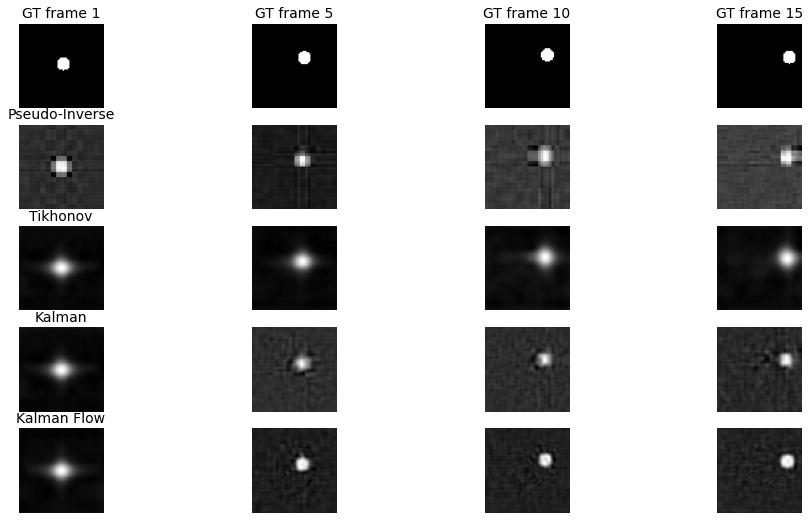

In [35]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 10]

nb_disp_frames = 4
outputs_0 = [x_gt, x_pseudo_inv ,x_tikhonov, x_kalman, x_kalman_f];
title_lists_0 = [["GT frame 1", "GT frame 5", "GT frame 10", "GT frame 15"]]
title_lists_0.append(["Pseudo-Inverse"]+["" for i in range(3)])
title_lists_0.append(["Tikhonov"]+["" for i in range(3)])
title_lists_0.append(["Kalman"]+["" for i in range(3)])
title_lists_0.append(["Kalman Flow"]+["" for i in range(3)])
# title_lists_0.append(["" for i in range(4)])
compare_video_frames(outputs_0, nb_disp_frames, title_lists_0,savefig = '');

We observe that there are a few parasite pixels that articially make us lose the contrast, but the image quality ignoring those pixels is actually good!
Potential idea to stop this would be to force the pixels into the [-1,1] range. To do that, see Kalman filter with equality constraints.

# 4 - Joint motion and image estimation via single-pixel imaging
## 4.1 - Theory
For this part, we work under the assumption that we have a dual SPC-RGB camera. Under those circumstances, we can at any given time estimate the optical flow thanks to the RGB camera. So we assume that for every time step $t$, we know $(\hat{\mathbf{u}}_t, \hat{\mathbf{v}}_t) \in \mathbb{R}^{2 \times N}$ such that 
\begin{equation*}
\mathbf{f}_{t+1} \approx \mathcal{W}(\mathbf{f}_{t}, \hat{\mathbf{u}}_t, \hat{\mathbf{v}}_t),
\label{eq:flow} \tag{18}
\end{equation*}

Contrary to the previous section though, we improve the flow estimation provided by the RGB camera. We use the Kalman Filter to estimate the "real" optical flow $\mathbf{U}_t = (\mathbf{u}_t, \mathbf{v}_t) \in \mathbb{R}^{2N}$, where the measured vector $\hat{\mathbf{U}}_t = (\hat{\mathbf{u}}_t, \hat{\mathbf{v}}_t)$, and the optical flow follow
\begin{equation*}
\begin{cases}
    \mathbf{U}_{t+1} = \mathbf{U}_{t} + \nu_t,\\
    \mathbf{U}_{t} = \hat{\mathbf{U}}_{t+1} + \hat{\nu}_{t},
  \end{cases}
\label{eq:general_formulation} \tag{19}
\end{equation*}
where 
\begin{align}
\nu_{t} \sim \mathcal{N}( \mathbf{0}, \mathbf{B}_t), \label{eq:meas_noise} \tag{20.1}\\
\hat{\nu}_{t} \sim \mathcal{N}( \mathbf{0}, \hat{\mathbf{B}}_t). \label{eq:mod_noise} \tag{20.2}
\end{align}
We make the hypothesis that the flow is similar from one frame to the next one.


As we do not have samples of the "true" optical flow, obtaining an estimation of $\mathbf{B}_t$ and $\hat{\mathbf{B}}_t$ is a challenging task. We therefore define $\mathbf{B}_t$ and $\mathbf{B}_t$ as a hand-crafted parameters i.e.
\begin{align}
\mathbf{B}_t = b \mathbf{I} \quad \forall t \in \mathbb{N}. \label{eq:appeox_cov_flow} \tag{21.1}\\
\hat{\mathbf{B}}_t = \hat{b} \mathbf{I} \quad \forall t \in \mathbb{N}. \label{eq:appeox_cov_flow_meas} \tag{21.2}\\
\end{align}

This flow esimtation happens before the estimation of the current frame. The final algorithm looks like this :


### Flow Estimation
* **Initialisation** : $\mathbf{f}^+_0$, $\mathbf{C}_0^+$ are obtained by :
 * $\mathbf{U}^+_0 = \mathbb{E}(\mathbf{f}_0|\mathbf{m}^\alpha_0)$.
 * $\mathbf{D}_0^+ = \mathbb{V}\text{ar}(\mathbf{U}_0|\hat{\mathbf{U}}_0)$
* **Itérations**
    * **Prior Estimation**
\begin{align}
    \mathbf{U}^-_{t+1} & =  \mathbf{U}^+_{t},  \label{eq:prior_mean_flow} \tag{22.1}\\
    \mathbf{D}^-_{t+1} & = \mathbf{D}^+_{t} + b\mathbf{I},
    \label{eq:prior_var_flow} \tag{22.2}
\end{align}
    * **Posterior Estimation**
\begin{align}
    \mathbf{U}^+_{t+1} & = \mathbf{U}_{t+1}^- + \mathbf{D}_{t+1}^- (\mathbf{D}_{t+1}^- + \hat{b}\mathbf{I})^{-1}(\hat{\mathbf{U}}_{t+1} - \mathbf{U}_{t+1}^-) \label{eq:post_mean_flow} \tag{23.1}\\
    \mathbf{D}^+_{t+1} & = \mathbf{D}_{t+1}^- - \mathbf{D}_{t+1}^- (\mathbf{D}_{t+1}^- + \hat{b}\mathbf{I})^{-1} \mathbf{D}_{t+1}^{- \top} \label{eq:post_var_flow} \tag{23.2}
\end{align}



### Image estimation
The reconstruction scheme with the Kalman filter then becomes

* **Initialisation** : $\mathbf{f}^+_0$, $\mathbf{C}_0^+$ are obtained by :
 * $\mathbf{f}^+_0 = \mathbb{E}(\mathbf{f}_0|\mathbf{m}^\alpha_0)$.
 * $\mathbf{C}_0^+ = \mathbb{V}\text{ar}(\mathbf{f}_0|\mathbf{m}^\alpha_0)$

* **Itérations**
    * **Prior Estimation**
\begin{align}
    \mathbf{f}^-_{t+1} & =  \mathcal{W}(\mathbf{f}^+_{t}, \mathbf{u}^+_{t+1}, \mathbf{v}^+_{t+1}),  \label{eq:prior_mean_gauss} \tag{24.1}\\
    \mathbf{C}^-_{t+1} & = \mathbf{A}_t \mathbf{C}^+_{t} \mathbf{A}_t^\top + \mathbf{\Sigma},
    \label{eq:prior_var_gauss} \tag{24.2}
\end{align}
where $\mathbf{A}_t$ is the first derrivative of $\mathcal{W}$ with respect to $\mathbf{f}$, i.e.
\begin{align}
\mathbf{A}_t = \frac{\partial \mathcal{W}}{\partial \mathbf{f}}(\mathbf{f}^+_{t}, \hat{\mathbf{u}}_{t+1}, \hat{\mathbf{v}}_{t+1}) = \mathbf{I}+\text{Diag}(\hat{\mathbf{u}}_{t+1}) \nabla_x + \text{Diag}(\hat{\mathbf{v}}_{t+1}) \nabla_y \label{eq:linearised_warp} \tag{25}
\end{align}

    * **Posterior Estimation**
\begin{align}
    \mathbf{f}^+_{t+1} & = \mathbf{f}_{t+1}^- + \mathbf{C}_{t+1}^- \mathbf{P}_{t+1}^\top (\mathbf{P}_{t+1} \mathbf{C}_{t+1}^- \mathbf{P}_{t+1}^\top+ \mathbf{\Sigma}^\alpha_{t+1})^{-1}(\mathbf{m}_{t+1}^\alpha - \mathbf{P}_{t+1} \mathbf{f}_{t+1}^-) \label{eq:post_mean_gauss} \tag{26.1}\\
    \mathbf{C}^+_{t+1} & = \mathbf{C}_{t+1}^- - \mathbf{C}_{t+1}^- \mathbf{P}_{t+1}^\top (\mathbf{P}_{t+1} \mathbf{C}_{t+1}^- \mathbf{P}_{t+1}^\top+ \mathbf{\Sigma}^\alpha_{t+1})^{-1}\mathbf{P}_{t+1} \mathbf{C}_{t+1}^{- \top} \label{eq:post_var_gauss} \tag{26.2}
\end{align}

## 4.2 - Numerical Simulations

In [36]:
def Flow_kalman_prior(u_k, D_k, b):
    """"
        Flatten the flow + do operations
    """
    u_k1 = np.reshape(u_k, (np.prod(u_k.shape)));
    D_k1 = D_k+b*sparse.eye(np.prod(u_k.shape));
    return u_k1, D_k1;

def Flow_Kalman_posterior(U_k, u_k, D_k, b_tilde):
    K_k = D_k+b_tilde*sparse.eye(np.prod(u_k.shape));
    # print(K_k.shape)
    K_k = sparse.linalg.inv(K_k.tocsc());
    K_k = D_k@K_k;
    u_k1 = u_k + K_k@(np.reshape(U_k, (np.prod(u_k.shape)))-u_k);
    D_k1 = D_k - K_k@D_k.T;
    return u_k1, D_k1

def Flow_kalman_step(U_k, u_k, D_k, b, b_tilde):
    # Prior estimation
    u_k, D_k = Flow_kalman_prior(u_k, D_k, b);
    # Posterior estimation
    u_k, D_k = Flow_Kalman_posterior(U_k, u_k, D_k, b_tilde);
    return u_k, D_k;

In [37]:
x_kal_flow_2 = np.zeros((n_frames+1, img_size, img_size))
b = 0.1;
b_tilde = 0.1; 
D_k = sparse.eye(2*img_size**2) # we assume an initial standard deviation in the flow of about 1 pixels (which is pretty high)
flow_prev = np.zeros((img_size,img_size, 2))
for t in range(n_frames):
    print("time =  {}".format(t))
    H_k = extract_high_low_res_matrices(H_perm, t, M, L0, L1)
    One = np.dot(H_k, np.ones((img_size**2,1))) # Optimisable (je le dis tout de suite)!
    
    ## Measurement acquisition
    x_k = (x[t,:,:]+1)/2;
    x_k = np.reshape(x_k, (img_size**2, 1));
    y_k_pos, y_k_neg = measure(H_k, x_k , N0);
    Sigma_a = (y_k_pos+y_k_neg)/(4*N0**2);
    y_k = y_k_pos-y_k_neg;
    y_k = 2/N0*y_k - One;
    Sigma_a = diag(Sigma_a);
    
    ## Image reconstruction
    if t == 0:
        t1 = time.time();
        x_kalman_f_2, P_k = Denoi_stat_comp(y_k, Sigma_i, Sigma_a, H_k);
        t2 = time.time();
        print("Kalman time = {}".format(t2-t1))
    else:
        t1 = time.time();
        flow = flow_farneback(np.reshape(x_prev,(img_size,img_size)),np.reshape(x_k,(img_size,img_size)));
        flow, D_k = Flow_kalman_step(flow, flow_prev, D_k, b, b_tilde);
        flow = np.reshape(flow,(img_size, img_size, 2)).astype('float32');
        flow_prev = flow; 
        # imagesc(flow[:,:,0])
        Fx = diags(np.reshape(-flow[:,:,0],(img_size**2)))@Dx;
        Fy = diags(np.reshape(-flow[:,:,1],(img_size**2)))@Dy;
        # Key steps to avoid exploding covariance!!!!! Change sparse type : CSC-> LIL -> remove 0's -> CSC
        A_t = (Fx+Fy).tolil()
        A_t[A_t<0.01*np.amax(A_t)]=0;
        A_t = A_t.tocsc();
        ############################################
        x_kalman_f_2, P_k = Kalman_flow_step(y_k, x_kalman_f_2, H_k, P_k, Cov_dyn_sp, Sigma_a, A_t, flow); 
        t2 = time.time();
        print("Kalman time = {}".format(t2-t1))
    x_kal_flow_2[t+1,:,:] = np.reshape(x_kalman_f_2, (img_size, img_size))
    x_prev = x_k

    


time =  0
H0 = [0,125]
H1 = [125,250]
Kalman time = 0.2421727180480957
time =  1
H0 = [0,125]
H1 = [250,375]
Kalman time = 3.6524646282196045
time =  2
H0 = [0,125]
H1 = [375,500]
Kalman time = 3.560030698776245
time =  3
H0 = [0,125]
H1 = [500,625]
Kalman time = 3.4067203998565674
time =  4
H0 = [0,125]
H1 = [125,250]
Kalman time = 3.582146406173706
time =  5
H0 = [0,125]
H1 = [250,375]
Kalman time = 3.38043475151062
time =  6
H0 = [0,125]
H1 = [375,500]
Kalman time = 3.4660818576812744
time =  7
H0 = [0,125]
H1 = [500,625]
Kalman time = 3.4202282428741455
time =  8
H0 = [0,125]
H1 = [125,250]
Kalman time = 3.4538307189941406
time =  9
H0 = [0,125]
H1 = [250,375]
Kalman time = 3.4361071586608887
time =  10
H0 = [0,125]
H1 = [375,500]
Kalman time = 3.5001978874206543
time =  11
H0 = [0,125]
H1 = [500,625]
Kalman time = 3.456733226776123
time =  12
H0 = [0,125]
H1 = [125,250]
Kalman time = 3.601971387863159
time =  13
H0 = [0,125]
H1 = [250,375]
Kalman time = 3.5390124320983887
time =  

In [38]:
x_kalman_f_2 = np.zeros((1,4,1,img_size, img_size));
x_kalman_f_2[0,0,0,:,:] = x_kal_flow_2[1,:,:]
x_kalman_f_2[0,1,0,:,:] = x_kal_flow_2[5,:,:]
x_kalman_f_2[0,2,0,:,:] = x_kal_flow_2[10,:,:]
x_kalman_f_2[0,3,0,:,:] = x_kal_flow_2[15,:,:]
x_kalman_f_2.shape

(1, 4, 1, 64, 64)

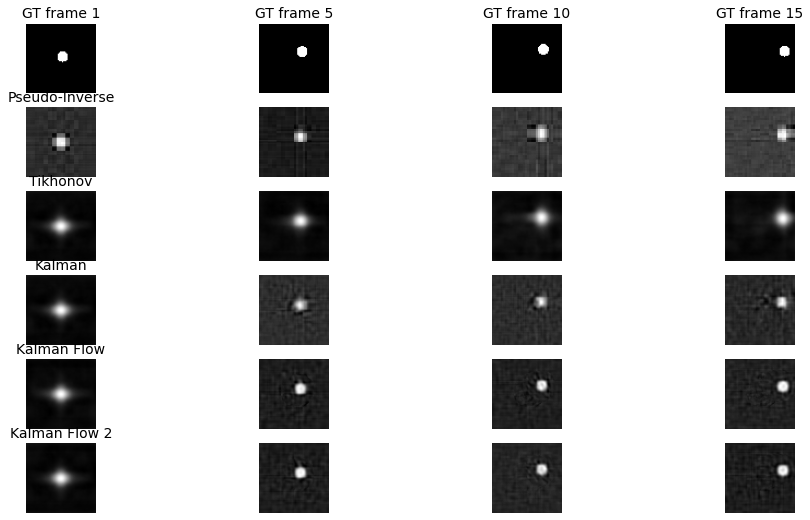

In [39]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 10]

nb_disp_frames = 4
outputs_0 = [x_gt, x_pseudo_inv ,x_tikhonov, x_kalman, x_kalman_f, x_kalman_f_2];
title_lists_0 = [["GT frame 1", "GT frame 5", "GT frame 10", "GT frame 15"]]
title_lists_0.append(["Pseudo-Inverse"]+["" for i in range(3)])
title_lists_0.append(["Tikhonov"]+["" for i in range(3)])
title_lists_0.append(["Kalman"]+["" for i in range(3)])
title_lists_0.append(["Kalman Flow"]+["" for i in range(3)])
title_lists_0.append(["Kalman Flow 2"]+["" for i in range(3)])
# title_lists_0.append(["" for i in range(4)])
compare_video_frames(outputs_0, nb_disp_frames, title_lists_0,savefig = '');

Conclusion : too time consuming, and no visible gains with respect to the first option.

# 5- Motion estimation through acceleration of the flow (Aborted)
## 5.1 - Theory

Contrary to the previous section, we improve the flow estimation provided by the RGB camera even further by adding information on the accelaration through the system equation. We use the Kalman Filter to estimate the "real" optical flow $\mathbf{U}_t = (\mathbf{u}_t, \mathbf{v}_t) \in \mathbb{R}^{2N}$ alongside with the acceleration of the flow $\mathbf{a}_t = (\mathbf{a}^u_t, \mathbf{a}^v_t) \in \mathbb{R}^{2N}$, where the measured vector $\hat{\mathbf{U}}_t = (\hat{\mathbf{u}}_t, \hat{\mathbf{v}}_t)$, the optical flow and the acceleration follow
\begin{equation*}
\begin{cases}
    \mathbf{U}_{t+1} = \mathbf{U}_{t} + \mathbf{A}_{t} + \nu_t,\\
    \mathbf{a}_{t+1} = \mathbf{a}_{t} + \zeta_t\\
    \hat{\mathbf{U}}_{t} = \mathbf{U}_{t+1} + \hat{\nu}_{t},
  \end{cases}
\label{eq:general_formulation} \tag{27}
\end{equation*}
where 
\begin{align}
\nu_{t} \sim \mathcal{N}( \mathbf{0}, \mathbf{B}_t), \label{eq:meas_noise} \tag{28.1}\\
\hat{\nu}_{t} \sim \mathcal{N}( \mathbf{0}, \hat{\mathbf{B}}_t). \label{eq:mod_noise} \tag{28.2} \\
\zeta_{t} \sim \mathcal{N}( \mathbf{0}, \tilde{\mathbf{B}}_t). \label{eq:mod_noise_acc} \tag{28.3} \\
\end{align}
We make the hypothesis that the acceleration has very little variation between the different frames.


As we do not have samples of the "true" optical flow or the acceleration, obtaining an estimation of $\mathbf{B}_t$, $\hat{\mathbf{B}}_t$ or $\tilde{\mathbf{B}}_t$ is a challenging task. We therefore define $\mathbf{B}_t$, $\mathbf{B}_t$ and $\tilde{\mathbf{B}}_t$ as a hand-crafted parameters i.e.
\begin{align}
\mathbf{B}_t = b \mathbf{I} \quad \forall t \in \mathbb{N}. \label{eq:appeox_cov_flow} \tag{29.1}\\
\hat{\mathbf{B}}_t = \hat{b} \mathbf{I} \quad \forall t \in \mathbb{N}. \label{eq:appeox_cov_flow_meas} \tag{29.2}\\
\tilde{\mathbf{B}}_t = \tilde{b} \mathbf{I} \quad \forall t \in \mathbb{N}. \label{eq:appeox_cov_accel_meas} \tag{29.3}\\
\end{align}

This flow esimtation happens before the estimation of the current frame. 
Writing $\mathbf{V}_t = [\mathbf{a}_t, U\mathbf{U}_t]$ the system can be written as 

\begin{equation*}
\begin{cases}
    \mathbf{V}_{t+1} = \mathbf{T}\mathbf{V}_{t} + \tilde{\zeta}_t,\\
    \hat{\mathbf{U}}_{t} = \mathbf{U}_{t+1} + \hat{\nu}_{t},
  \end{cases}
\label{eq:flow_acc} \tag{30}
\end{equation*}

Where $\mathbf{T} = \begin{bmatrix}\mathbf{I} & \mathbf{I}\\ \mathbf{0} & \mathbf{I}\end{bmatrix}$.

### Flow & Acceleration Estimation
* **Initialisation** : $\mathbf{f}^+_0$, $\mathbf{C}_0^+$ are obtained by :
 * $\mathbf{U}^+_0 = \mathbb{E}(\mathbf{f}_0|\mathbf{m}^\alpha_0)$.
 * $\mathbf{a}^+_0 = \mathbb{E}(\mathbf{f}_0|\mathbf{m}^\alpha_0)$.
 * $\mathbf{D}_0^+ = \mathbb{V}\text{ar}(\mathbf{U}_0|\hat{\mathbf{U}}_0)$
* **Itérations**
    * **Prior Estimation**
\begin{align}
    \mathbf{V}^-_{t+1} & =  \mathbf{TV}^+_{t},  \label{eq:prior_mean_flow} \tag{31.1}\\
    \mathbf{D}^-_{t+1} & = \mathbf{T}\mathbf{D}^+_{t}\mathbf{T}^\top + b\mathbf{I},
    \label{eq:prior_var_flow} \tag{31.2}
\end{align}
    * **Posterior Estimation**
\begin{align}
    \mathbf{V}^+_{t+1} & = \mathbf{U}_{t+1}^- + \mathbf{D}_{t+1}^- (\mathbf{D}_{t+1}^- + \hat{\mathbf{B}}_{t+1})^{-1}(\hat{\mathbf{U}}_{t+1} - \mathbf{U}_{t+1}^-) \label{eq:post_mean_flow} \tag{32.1}\\
    \mathbf{D}^+_{t+1} & = \mathbf{D}_{t+1}^- - \mathbf{D}_{t+1}^- (\mathbf{D}_{t+1}^- + \hat{\mathbf{B}}_{t+1})^{-1} \mathbf{D}_{t+1}^{- \top} \label{eq:post_var_flow} \tag{32.2}
\end{align}



### Image estimation
The reconstruction scheme with the Kalman filter then becomes

* **Initialisation** : $\mathbf{f}^+_0$, $\mathbf{C}_0^+$ are obtained by :
 * $\mathbf{f}^+_0 = \mathbb{E}(\mathbf{f}_0|\mathbf{m}^\alpha_0)$.
 * $\mathbf{C}_0^+ = \mathbb{V}\text{ar}(\mathbf{f}_0|\mathbf{m}^\alpha_0)$

* **Itérations**
    * **Prior Estimation**
\begin{align}
    \mathbf{f}^-_{t+1} & =  \mathcal{W}(\mathbf{f}^+_{t}, \mathbf{u}^+_{t+1}, \mathbf{v}^+_{t+1}),  \label{eq:prior_mean_gauss} \tag{33.1}\\
    \mathbf{C}^-_{t+1} & = \mathbf{A}_t \mathbf{C}^+_{t} \mathbf{A}_t^\top + \mathbf{\Sigma},
    \label{eq:prior_var_gauss} \tag{33.2}
\end{align}
where $\mathbf{A}_t$ is the first derrivative of $\mathcal{W}$ with respect to $\mathbf{f}$, i.e.
\begin{align}
\mathbf{A}_t = \frac{\partial \mathcal{W}}{\partial \mathbf{f}}(\mathbf{f}^+_{t}, \hat{\mathbf{u}}_{t+1}, \hat{\mathbf{v}}_{t+1}) = \mathbf{I}+\text{Diag}(\hat{\mathbf{u}}_{t+1}) \nabla_x + \text{Diag}(\hat{\mathbf{v}}_{t+1}) \nabla_y \label{eq:linearised_warp} \tag{34}
\end{align}

    * **Posterior Estimation**
\begin{align}
    \mathbf{f}^+_{t+1} & = \mathbf{f}_{t+1}^- + \mathbf{C}_{t+1}^- \mathbf{P}_{t+1}^\top (\mathbf{P}_{t+1} \mathbf{C}_{t+1}^- \mathbf{P}_{t+1}^\top+ \mathbf{\Sigma}^\alpha_{t+1})^{-1}(\mathbf{m}_{t+1}^\alpha - \mathbf{P}_{t+1} \mathbf{f}_{t+1}^-) \label{eq:post_mean_gauss} \tag{35.1}\\
    \mathbf{C}^+_{t+1} & = \mathbf{C}_{t+1}^- - \mathbf{C}_{t+1}^- \mathbf{P}_{t+1}^\top (\mathbf{P}_{t+1} \mathbf{C}_{t+1}^- \mathbf{P}_{t+1}^\top+ \mathbf{\Sigma}^\alpha_{t+1})^{-1}\mathbf{P}_{t+1} \mathbf{C}_{t+1}^{- \top} \label{eq:post_var_gauss} \tag{35.2}
\end{align}


## 5.2 - Numerical simulations

/|\ ABORTED : Lack of improvement on previous method makes it difficult to justify going for this method. This method would be even more time consuming, and it wouldn't necessarily improve the current results significantly. The Farneback method is accurate enough that we don't need extra improvements for a rough estimate.

# Conclusion
We have studied through a toy-example the use of the Kalman filter for single-pixel video reconstruction.

* (Kalman) Kalman filter with no flow estimation (the current frame is the same as the previous frame - with a bit of noise).
    * Serious improvement over tikhonov and pseudo inverse
    * Artifacts along the edges where there is some movement
    * 7 Times slower than tikhonov and pseudo inverse : needs some optimisation 

* (Kalman Flow) Extended Kalman filter with Farneback flow estimation (the current frame is the previous frame, warped - with a bit of noise).
    * Improvement with respect to (Kalman) : removes artefacts from the edges where there is movement.
    * Stable covariance matrix over time.
    * 10 times slower than tikhonov and pseudo inverse : needs some optimisation

* (Kalman Flow 2) Extended Kalman filter with Farneback+Kalman flow estimation
    * No real improvement over (Kalman Flow)
    * Computationally expensive (~3 sec for flow estimation) - would really need optimisation if kept(if at all doable).

Keeping Kalman and Kalman flow seems reasonable, but it needs to be significantly optimised.

- Imposing a constant gain for the Kalman filter (look for constant gain Kalman filter) would reduce the computational burden
- Further exploring the use of sparse matrix (although they are already being used, but perhaps not optimally!)
- Artifacts may appear every now and again : adding [-1,1] constraints may be necessary to guarantee extra stability and that we always visualise images with proper contrast.
- Using Deep-learning to optimize the inversion of the matrix in the posterior estimation.


# Additional Perspectives 

* Using optical flow from the previous frames to estimate the current optical flow (that way there is no need to use the RGB camera).
* Adding handcrafted covariance matrices that use the optical flow to determine the Covariance matrix used in the update step.

# Annexe - Crétation des motifs expérimentaux pour la manip

In [40]:
def img_to_DMD(pattern, shape, Upsample):
    DMD_img = np.zeros(shape);
    Pat = cv2.resize(pattern, Upsample, interpolation = cv2.INTER_NEAREST);
    start_x_index = int((shape[0]-Upsample[0])/2);
    start_y_index = int((shape[1]-Upsample[1])/2);
    end_x_index = int((shape[0]-Upsample[0])/2)+Upsample[0];
    end_y_index = int((shape[1]-Upsample[1])/2)+Upsample[1];
    DMD_img[start_x_index:end_x_index, start_y_index:end_y_index] = Pat;
    return DMD_img;

def save_patterns_posneg(H, shape = (768, 1024), Upsample = (768, 768), n = None):
    M ,N = H.shape;
    
    if n is None:
        n = int(np.sqrt(N));

    even_index = range(0,2*M,2);
    odd_index = range(1,2*M,2);

    H_pos = np.zeros(H.shape);
    H_neg = np.zeros(H.shape);
    H_pos[H>0] = H[H>0];
    H_neg[H<0] = -H[H<0];
    Hposneg = np.zeros((2*M,N));
    Hposneg[even_index,:] = H_pos;
    Hposneg[odd_index,:] = H_neg;
    # print(Hposneg)
    for i in range(Hposneg.shape[0]):
        pattern = np.reshape(Hposneg[i,:],(n,n))
        # print(pattern)
        pattern = float2_bit_0_1(img_to_DMD(pattern, shape, Upsample));
        cv2.imwrite('./data/posneg/Walsh_64x64_{}.png'.format(i), pattern)
        


In [41]:
# n_frames = 4
# H_tot = np.zeros((0,img_size**2));
# for t in range(n_frames):
#     print("time =  {}".format(t))
#     H_k = extract_high_low_res_matrices(H_perm, t, M, L0, L1)
#     H_tot = np.concatenate((H_tot, H_k), axis = 0)

# save_patterns_posneg(H_tot)